In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of data points
NUM_SAMPLES = 1000

# --- Model Parameters ---
MU_MAX = 0.86980    # 1/h
K_S = 0.000123762    # g/l
Y_XS = 0.435749      # g/g
S_F = 286           # g/l
K_I    = 33           # g/l
k_d    = 0.03        # 1/h

# Noise parameters
BIOMASS_NOISE = 0.005
SUBSTRATE_NOISE = 0.005

# Initial Conditions
X_0, S_0, V_0 = 5, 0.013, 1.7  # Biomass, Substrate, Volume


# ODE solver parameters
ODE_SOLVER = 'LSODA'

# Time parameters
T_START = 0
T_END = 6
TIME_RANGE = int(T_END - T_START) # Absolute time 

# Actual system dynamics
def actual_system(t: float, y: float, F: float):
    ''' Real system model with cell death and substrate inhibition '''
    X, S, V = y
    mu = MU_MAX * S / (K_S + S + S**2 / K_I)  # Monod equation
    dX_dt = mu * X - (F / V) * X - k_d * X
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S) 
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

def plot_solution(sol: solve_ivp) -> None:
    plt.figure(figsize=(12,4))
    plt.plot(sol.t, sol.y[0], label='Biomass')
    plt.plot(sol.t, sol.y[1], label='Substrate')
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/l)')
    plt.legend()
    plt.show()
    

In [2]:
# MPC parameters
dt = 0.1                         # Time step
L = int(TIME_RANGE / dt)       # Number of steps
N_p =  5                       # Prediction horizon
Q = 2.5                         # Weight for tracking
R = 0.01                            # Weight for control effort
Q_term = 0.0                     # Weight for terminal state
OPTIMIZATION_METHOD = 'COBYLA' # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

# Bounds for feeding rate
F_MIN = 0.0                  # l/h
F_MAX = 0.1                  # l/h
DELTA_F_MAX = 0.05           # Maximum change in feed rate
F_0 = (F_MAX - F_MIN) / 2    # Initial feed rate
BOUNDS = [(F_MIN, F_MAX) for _ in range(N_p)] 

# X_setpoint
X_sp = 30

print(f'Number of steps: {L} and dt: {dt}')

Number of steps: 60 and dt: 0.1


In [3]:
# Load torch model
model_name = "pinc_model_br_v3.pth"
model_exists = os.path.exists(f'./models/{model_name}')

def numpy_to_tensor(array, requires_grad=False):
    return torch.tensor(array, requires_grad=requires_grad, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

class PINN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.input = nn.Linear(input_dim, 64)
        self.hidden1 = nn.Linear(64, 1024)
        self.hidden  = nn.Linear(1024, 1024)
        self.hidden2 = nn.Linear(1024, 64)
        self.output = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden(x))
        x = torch.tanh(self.hidden2(x))
        x = self.output(x)
        return x
                        
if model_exists:
    net = PINN(input_dim=5, output_dim=3).to(DEVICE)
    net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
    net.eval()
else:
    raise FileNotFoundError(f"Model file './models/{model_name}' does not exist.")

In [4]:
# ----- Cost function -----
def cost_function(F_opt: list, X: float, S: float, V: float, T_s: float) -> float:
    X_ts, S_ts, V_ts, F_ts = map(numpy_to_tensor, (X, S, V, F_opt))
    J = 0.0
    for k in range(N_p):
        y_k = net.forward(torch.tensor([T_s, X_ts, S_ts, V_ts, F_ts[k]], device=DEVICE))
        X_next, S_next, V_next = y_k[0], y_k[1], y_k[2]
        
        J += Q * (X_sp - X_next.item()) ** 2
                
        if k > 0:
            J += R * (F_opt[k] - F_opt[k - 1]) ** 2
            
        X_ts, S_ts, V_ts = X_next, S_next, V_next
    
    return J

In [5]:
X = np.zeros(L)
S = np.zeros(L)
V = np.zeros(L)
F = np.zeros(L)
X[0], S[0], V[0] = X_0, S_0, V_0

for i in tqdm(range(L-1)):
    res = minimize(cost_function, np.zeros(N_p), args=(X[i], S[i], V[i], dt), bounds=BOUNDS, method=OPTIMIZATION_METHOD)
    F_new = res.x[0]
    F[i+1] = F_new
    sol = solve_ode(actual_system, t_span=[0, dt], y0=[X[i], S[i], V[i]], method=ODE_SOLVER, t_eval=[dt], args=(F_new,))
    sol.y[0][-1] += np.random.normal(0, max(0, sol.y[0][-1]) * BIOMASS_NOISE, size=sol.y[0][-1].shape)
    sol.y[1][-1] += np.random.normal(0, max(0, sol.y[1][-1]) * SUBSTRATE_NOISE, size=sol.y[1][-1].shape)
    X[i+1] = sol.y[0][-1]
    S[i+1] = sol.y[1][-1]
    V[i+1] = sol.y[2][-1]

100%|██████████| 59/59 [00:04<00:00, 13.38it/s]


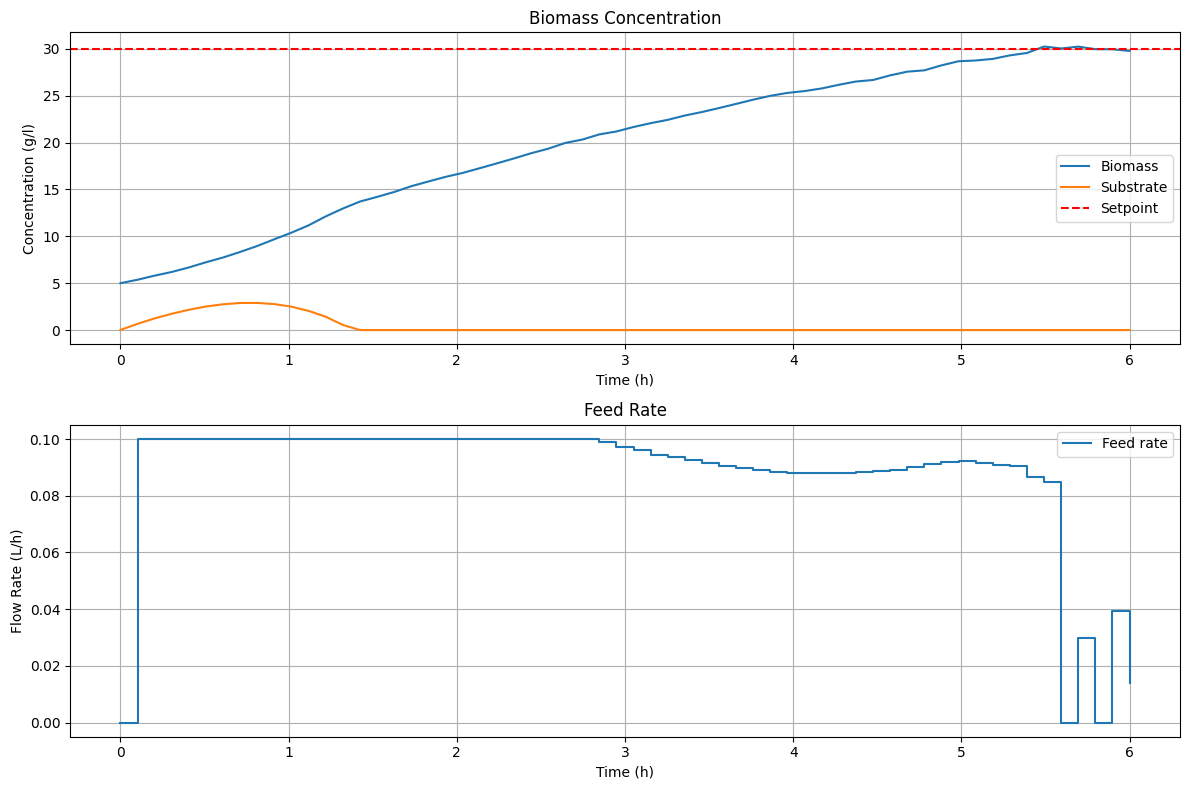

In [6]:
time= np.linspace(T_START, T_END, L)
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(time, X, label='Biomass')
plt.plot(time, S, label='Substrate')
plt.axhline(y=X_sp, color='r', linestyle='--', label='Setpoint')
plt.title('Biomass Concentration')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.step(time, F, label='Feed rate', where='post')
plt.title('Feed Rate')
plt.xlabel('Time (h)')
plt.ylabel('Flow Rate (L/h)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Evaluate using real system dynamics

/home/kostasme/.kostas/lib/python3.11/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: The following arguments have no effect for a chosen solver: `atols`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


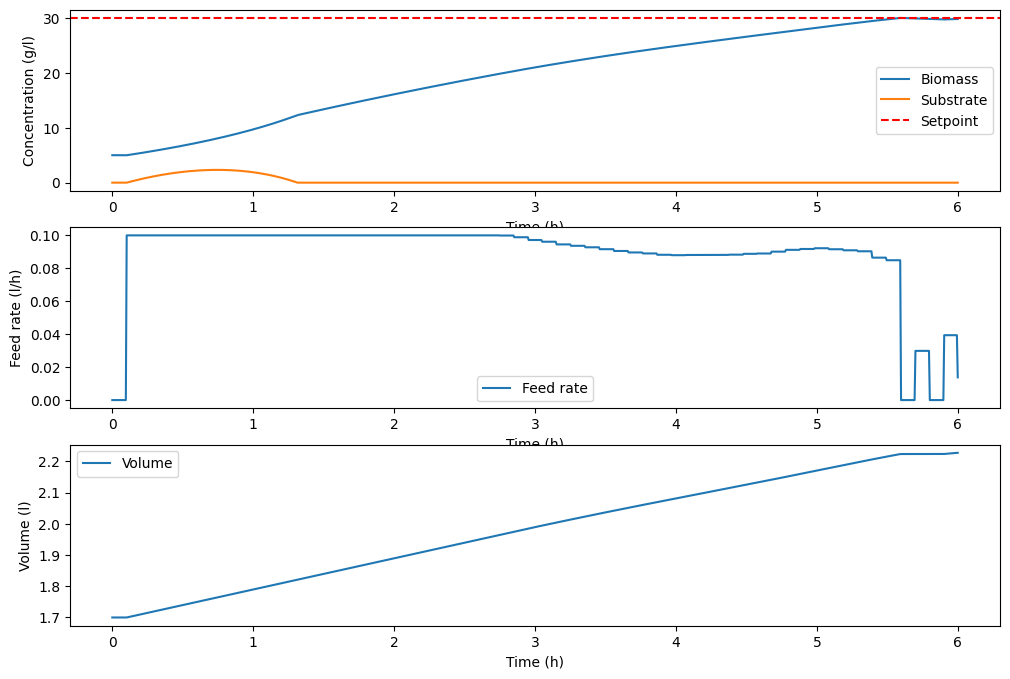

In [7]:
from scipy.interpolate import interp1d

# System dynamics
def simulate(t, y, F_func) -> np.array:
    
    F = F_func(t)   
    
    X, S, V = y
    dX_dt = (MU_MAX * S / (K_S + S + S**2 / K_I)) * X - (F / V) * X - k_d * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt,dV_dt])

# Actual system dynamics
def actual_system(t: float, y: float, F: float):
    ''' Real system model with cell death and substrate inhibition '''
    X, S, V = y
    mu = MU_MAX * S / (K_S + S + S**2 / K_I)  # Monod equation
    dX_dt = mu * X - (F / V) * X - k_d * X
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S) 
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]


F_func = interp1d(time, F, kind='previous', fill_value='extrapolate')
t_eval = np.linspace(T_START, T_END, NUM_SAMPLES)
sol = solve_ivp(simulate, t_span=[T_START, T_END], y0=[X_0, S_0, V_0], method=ODE_SOLVER, t_eval=t_eval, args=(F_func,), atols=1e-12, rtol=1e-12)

# Plot results
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(sol.t, sol.y[0], label='Biomass')
plt.plot(sol.t, sol.y[1], label='Substrate')
plt.axhline(y=X_sp, color='r', linestyle='--', label='Setpoint')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(sol.t, F_func(sol.t), label='Feed rate')
plt.xlabel('Time (h)')
plt.ylabel('Feed rate (l/h)')
plt.legend()

plt.subplot(3,1,3)
plt.plot(sol.t, sol.y[2], label='Volume')
plt.xlabel('Time (h)')
plt.ylabel('Volume (l)')
plt.legend()
plt.show()